In [ ]:
import random
import networkx as nx


class DynamicGraphSimulator:
    DURATION = 100  # seconds
    INIT_NODES = 30
    MIN_NODES = 23
    MAX_NODES = 37
    EDGE_UPDATE_PROB = 0.5  # 50% chance to update 1 or 2 edges
    EDGE_WEIGHT_UPDATE_PROB = 0.2  # 20% chance to update edge weight
    NODE_APPEAR_PROB = 0.15
    NODE_DISAPPEAR_PROB = 0.15
    EDGE_WEIGHT_MIN = 10
    EDGE_WEIGHT_MAX = 99

    def __init__(self):
        self.G = nx.Graph()
        self.next_node_id = self.INIT_NODES

    def ensure_connected(self):
        while not nx.is_connected(self.G):
            components = list(nx.connected_components(self.G))
            u = random.choice(list(components[0]))
            v = random.choice(list(components[1]))
            self.G.add_edge(u, v, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def random_edge(self):
        nodes = list(self.G.nodes)
        u, v = random.sample(nodes, 2)
        return (u, v)

    def add_random_edge(self):
        nodes = list(self.G.nodes)
        possible = [(u, v) for u in nodes for v in nodes if u != v and not self.G.has_edge(u, v)]
        if possible:
            u, v = random.choice(possible)
            self.G.add_edge(u, v, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def remove_random_edge(self):
        if self.G.number_of_edges() > self.G.number_of_nodes() - 1:
            edge = random.choice(list(self.G.edges))
            weight = self.G.edges[edge]['weight']
            self.G.remove_edge(*edge)
            if not nx.is_connected(self.G):
                self.G.add_edge(*edge, weight=weight)  # revert if disconnects

    def add_node(self):
        self.G.add_node(self.next_node_id)
        existing_nodes = set(self.G.nodes) - {self.next_node_id}
        existing = random.choice(list(existing_nodes))
        self.G.add_edge(self.next_node_id, existing, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))
        self.next_node_id += 1

    def remove_node(self):
        if self.G.number_of_nodes() > self.MIN_NODES:
            node = random.choice(list(self.G.nodes))
            edges = list(self.G.edges(node, data=True))
            self.G.remove_node(node)
            if not nx.is_connected(self.G):
                self.G.add_node(node)
                existing_nodes = set(self.G.nodes) - {node}
                existing = random.choice(list(existing_nodes))
                self.G.add_edge(node, existing, weight=random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX))

    def update_random_edge_weight(self):
        if self.G.number_of_edges() > 0:
            edge = random.choice(list(self.G.edges))
            self.G.edges[edge]['weight'] = random.randint(self.EDGE_WEIGHT_MIN, self.EDGE_WEIGHT_MAX)

    def get_graph_snapshot(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(range(self.INIT_NODES))
        for _ in range(self.INIT_NODES * 2):
            self.add_random_edge()
        self.ensure_connected()
        self.next_node_id = self.INIT_NODES

        for _ in range(5):
            if random.random() < self.NODE_APPEAR_PROB and self.G.number_of_nodes() < self.MAX_NODES:
                self.add_node()
            elif random.random() < self.NODE_DISAPPEAR_PROB and self.G.number_of_nodes() > self.MIN_NODES:
                self.remove_node()

            num_edge_updates = 1 if random.random() < self.EDGE_UPDATE_PROB else 2
            for _ in range(num_edge_updates):
                if random.random() < 0.5:
                    self.add_random_edge()
                else:
                    self.remove_random_edge()

            # Edge weight update
            if random.random() < self.EDGE_WEIGHT_UPDATE_PROB:
                self.update_random_edge_weight()

            self.ensure_connected()
        return self.G

In [2]:
import networkx as nx
from collections import defaultdict

class DynamicGraphClustering:
    def __init__(self):
        self.graph = nx.Graph()  # Current graph snapshot
        self.clusters = {}  # Node to cluster mapping
        self.cluster_data = defaultdict(set)  # Cluster to nodes mapping
    
    def initialize_clusters(self, k):
        """
        Initializes clusters for the first snapshot using k-means-like partitioning.
        """
        from sklearn.cluster import KMeans
        import numpy as np

        # Use degree centrality as a basic feature for clustering (can be extended)
        degrees = np.array([[d] for _, d in self.graph.degree()])
        kmeans = KMeans(n_clusters=k, random_state=42).fit(degrees)
        labels = kmeans.labels_

        # Assign clusters
        for node, cluster in zip(self.graph.nodes(), labels):
            self.clusters[node] = cluster
            self.cluster_data[cluster].add(node)
    
    def update_clusters(self, delta_edges):
        """
        Incrementally updates clusters based on graph snapshot changes.
        """
        affected_nodes = set()
        
        # Apply edge changes
        for edge, action in delta_edges:
            u, v = edge
            if action == "add":
                self.graph.add_edge(u, v)
            elif action == "remove":
                self.graph.remove_edge(u, v)
            affected_nodes.update([u, v])
        
        # Recompute clusters for affected nodes
        for node in affected_nodes:
            self.reassign_node_cluster(node)
    
    def reassign_node_cluster(self, node):
        """
        Reassigns a node to the best cluster based on its connections.
        """
        current_cluster = self.clusters.get(node, None)
        best_cluster = current_cluster
        best_score = self.calculate_cluster_score(node, current_cluster)

        # Test reassignment to each neighboring cluster
        neighbor_clusters = {self.clusters.get(neighbor) for neighbor in self.graph.neighbors(node)}
        for cluster in neighbor_clusters:
            score = self.calculate_cluster_score(node, cluster)
            if score > best_score:
                best_cluster = cluster
                best_score = score

        # Update cluster assignment if changed
        if best_cluster != current_cluster:
            if current_cluster is not None:
                self.cluster_data[current_cluster].remove(node)
            self.clusters[node] = best_cluster
            self.cluster_data[best_cluster].add(node)
    
    def calculate_cluster_score(self, node, cluster):
        """
        Calculates a score for assigning a node to a specific cluster.
        Currently uses modularity-like scoring.
        """
        if cluster is None:
            return 0
        cluster_nodes = self.cluster_data[cluster]
        internal_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor in cluster_nodes)
        return internal_edges
    
    def get_clusters(self):
        """
        Returns the current clustering as a dictionary.
        """
        return self.clusters



Initial clusters: {0: 1, 1: 0, 2: 1, 3: 1, 4: 4, 5: 1, 6: 2, 7: 1, 8: 0, 9: 2, 10: 2, 11: 1, 12: 0, 13: 0, 14: 2, 15: 0, 16: 0, 17: 1, 18: 0, 19: 4, 20: 4, 21: 0, 22: 4, 23: 1, 24: 2, 25: 1, 26: 2, 27: 0, 28: 4, 29: 0, 30: 4, 31: 1, 32: 4, 33: 4, 34: 0, 35: 2, 36: 0, 37: 0, 38: 2, 39: 0, 40: 0, 41: 1, 42: 4, 43: 4, 44: 1, 45: 0, 46: 3, 47: 0, 48: 4, 49: 0, 50: 0, 51: 4, 52: 1, 53: 4, 54: 2, 55: 3, 56: 2, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 1, 64: 3, 65: 1, 67: 0, 68: 4, 69: 2, 70: 0, 71: 3, 72: 4, 73: 2, 74: 1, 75: 1, 76: 4, 77: 2, 78: 1, 79: 4, 80: 0, 81: 4, 82: 1, 83: 1, 84: 0, 85: 2, 86: 1, 87: 1, 88: 0, 89: 4, 90: 0, 91: 4, 92: 4, 93: 0, 94: 1, 95: 1, 96: 0, 97: 4, 98: 0, 99: 0, 100: 1, 101: 0, 102: 2, 103: 2, 104: 4, 105: 0, 106: 0, 107: 0, 108: 2, 109: 0, 110: 1, 111: 1, 112: 2, 113: 4, 114: 4, 115: 0, 116: 4, 117: 0, 118: 2, 119: 0, 120: 1, 121: 1, 122: 4, 123: 2, 124: 4, 125: 0, 126: 0, 127: 0, 128: 1, 129: 0, 66: 1, 130: 1, 131: 1}

Snapshot 1:
Delta edges: [((13, 33


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\souri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


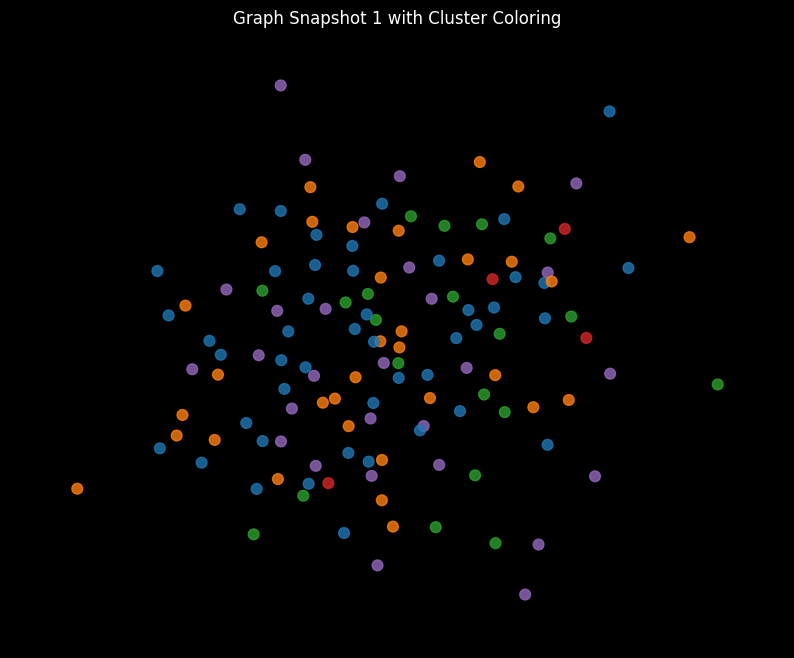

NetworkXError: The edge 86-127 is not in the graph

In [ ]:


# Main Driver

# Initialize generator and clustering system
generator = DynamicGraphSimulator()
generator.get_graph_snapshot()  # Generate initial graph snapshot
clustering_system = DynamicGraphClustering()

# Load the initial graph and initialize clusters
clustering_system.graph = generator.G
clustering_system.initialize_clusters(k=5)

print("Initial clusters:", clustering_system.get_clusters())

# Simulate dynamic graph snapshots
prev_edges = set(clustering_system.graph.edges())
for t in range(5):  # Process 5 snapshots
    print(f"\nSnapshot {t+1}:")
    generator.get_graph_snapshot()  # Update the graph to a new snapshot
    new_edges = set(generator.G.edges())
    # Compute delta: edges added or removed
    added = new_edges - prev_edges
    removed = prev_edges - new_edges
    delta = [((u, v), "add") for u, v in added] + [((u, v), "remove") for u, v in removed]
    print("Delta edges:", delta)

    # Update the clustering system's graph
    # Ensure matplotlib is installed and imported
    %pip install matplotlib
    import matplotlib.pyplot as plt

    clustering_system.graph = generator.G

    # Plot the graph with clusters colored
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(clustering_system.graph, seed=42)
    clusters = clustering_system.get_clusters()
    unique_clusters = list(set(clusters.values()))
    color_map = {c: plt.cm.tab10(i % 10) for i, c in enumerate(unique_clusters)}
    node_colors = [color_map[clusters[n]] for n in clustering_system.graph.nodes if n in clusters]

    nx.draw_networkx_edges(clustering_system.graph, pos, alpha=0.3)
    nx.draw_networkx_nodes(
        clustering_system.graph, pos,
        nodelist=[n for n in clustering_system.graph.nodes if n in clusters],
        node_color=node_colors,
        node_size=14,
        alpha=0.314
    )
    plt.title(f"Graph Snapshot {t+1} with Cluster Coloring")
    plt.axis('off')
    plt.show()
    # Update clusters incrementally
    clustering_system.update_clusters(delta)
    print("Updated clusters:", clustering_system.get_clusters())
    prev_edges = new_edges
